In [1]:
import instruments as inst
import copy
import numpy as np

# Step 1.a): Reading in csv - extracting single diffs and sums and configurations

In [2]:
file_path = "20230914_processed_table.csv"
wavelength_string = "675-50"
obs_mode = "IPOL"

interleaved_values, interleaved_stds, configuration_list = inst.read_csv(file_path, 
    obs_mode = obs_mode, obs_filter = wavelength_string)
print("Interleaved Values")
print("Length: ", len(interleaved_values))
print(interleaved_values)
print("Interleaved Stds")
print("Length: ", len(interleaved_stds))
print(interleaved_stds[0 : 10])
print("Configuration List")
print("Length: ", len(configuration_list))
print(configuration_list)
print(interleaved_stds[0])

Interleaved Values
Length:  320
[ -194.    7145.   -1810.    7200.    1175.    7123.   -2545.    7257.
  -590.    7238.5   -100.    7234.   -3741.    7605.    3334.    7381.
 -5838.    7690.    5192.    7350.   -4743.    7623.    3613.    7352.
  -998.    7285.    -433.    7265.    3133.5   7355.   -4335.    7712.
 -3066.    7450.     754.    7226.     229.    7210.   -2414.5   7298.
   986.    7222.   -2529.    7342.   -1417.    7338.     512.5   7289.
 -4874.    7685.    4197.    7409.   -6926.    7733.    5999.    7320.
 -5639.    7617.    4268.5   7287.   -1749.    7243.     145.    7180.5
 -4362.    7726.    2396.    7276.5  -1052.    7328.   -1443.    7333.
  1824.    7248.   -3867.    7652.    1763.    7297.   -3266.    7590.
 -1385.    7425.     324.    7377.   -5303.    7754.    4381.    7450.
 -7385.    7776.    6144.5   7323.   -5928.    7602.    4228.    7252.
 -3303.    7636.    1929.    7324.   -1709.    7411.25  -445.    7358.
  1655.    7301.   -3854.    7695.    3695. 

# Step 1.b) - Make plot of existing values as double diffs and sums

# Step 2: Creating a system Mueller matrix object

In [3]:
import numpy as np
past_fit = np.load("scipy_minimize_20230914_675nm_restrictive_HWP_and_IMR.npy")
print("Past Fit: ", past_fit)

Past Fit:  [ 1.53307627  0.46163077 -2.3687464   0.32815156 -4.99600063 -0.20433489
  0.02210595 18.49730849  0.52007057  4.99645591  1.19152714]


In [4]:
# Loading in previous fit from vampires_calibration
past_fit = np.load("scipy_minimize_20230914_675nm_restrictive_HWP_and_IMR.npy")
print("Past Fit: ", past_fit)

print(past_fit)

# theta_pol = past_fit[0]
# delta_HWP = past_fit[1]
# offset_HWP = past_fit[2]
# delta_derot = past_fit[3]
# offset_derot = past_fit[4]
# delta_opts = past_fit[5]
# epsilon_opts = past_fit[6]
# rot_opts = past_fit[7]
# delta_FLC = past_fit[8]
# rot_FLC = past_fit[9]
# em_gain = past_fit[10]

# Based on values in Six_And_Eleven_Parameter_Model_Best_MCMC_and_Scipy_Fits Google Sheets - having zeros for angles that're too large
theta_pol = 0
delta_HWP = 0.451  # Add your actual delta_HWP value
offset_HWP = -2.64  # Add your actual offset_HWP value
delta_derot = 0.32  # Add your actual delta_derot value
offset_derot = 0  # Add your actual offset_derot value
delta_opts = 0  # Add your actual delta_opts value
epsilon_opts = 0  # Add your actual epsilon_opts value
rot_opts = 0  # Add your actual rot_opts value
delta_FLC = 0.5  # Add your actual delta_FLC value
rot_FLC = 0  # Add your actual rot_FLC value
em_gain = 1.2  # Add your actual em_gain value

# NOTE: Components must be listed downstream to upstream
# Define the instrument configuration as a system dictionary
system_dict = {
    "components": {
        "wollaston": {
            "type": "wollaston_prism_function",
            "properties": {"beam": "o", "transmission_ratio": em_gain},
        },
        "flc": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_FLC, "theta": 0, "delta_theta": rot_FLC},
        },
        "optics": {
            "type": "diattenuator_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_opts, "epsilon": epsilon_opts, "theta": rot_opts},
        },
        "image_rotator": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_derot, "theta": 0, "delta_theta": offset_derot},
        },
        "hwp": {
            "type": "general_retarder_function",
            "properties": {"phi": 2 * np.pi * delta_HWP, "theta": 0, "delta_theta": offset_HWP},
        },
        "lp": {
            "type": "general_linear_polarizer_function_with_theta",
            "properties": {"theta": theta_pol},
        },
    }
}

Past Fit:  [ 1.53307627  0.46163077 -2.3687464   0.32815156 -4.99600063 -0.20433489
  0.02210595 18.49730849  0.52007057  4.99645591  1.19152714]
[ 1.53307627  0.46163077 -2.3687464   0.32815156 -4.99600063 -0.20433489
  0.02210595 18.49730849  0.52007057  4.99645591  1.19152714]


In [5]:
# Converting system dictionary into system Mueller Matrix object

system_mm = inst.generate_system_mueller_matrix(system_dict)
print(system_mm.evaluate())

[[0.59503851 0.59503851 0.         0.        ]
 [0.59503851 0.59503851 0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]]


# Step 4: Creating a dictionary of p0 starting guesses

logl value: 4056.4019629223058


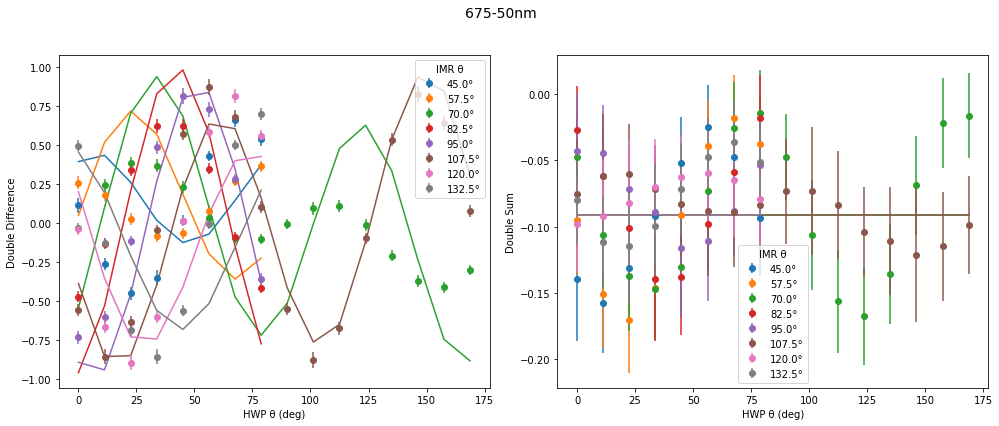

In [6]:
# Fittin for all parameters

p0 = {
    "wollaston": {"transmission_ratio": em_gain}, 
    "flc": {"phi": 2 * np.pi * delta_FLC, "delta_theta": rot_FLC},
    "optics": {"phi": 2 * np.pi * delta_opts, "epsilon": epsilon_opts, "theta": rot_opts},
    "image_rotator": {"phi": 2 * np.pi * delta_derot, "delta_theta": offset_derot},
    "hwp": {"phi": 2 * np.pi * delta_HWP, "delta_theta": offset_HWP},
    "lp": {"theta": theta_pol}
}

p0_values, p0_keywords = inst.parse_configuration(p0)
s_in = np.array([1, 0, 0, 0])
logl_value = inst.logl(p0_values, p0_keywords, system_mm, interleaved_values, interleaved_stds, configuration_list,
    s_in=s_in, logl_function=None, process_dataset=inst.process_dataset, process_errors=inst.process_errors, 
    process_model=inst.process_model)
print("logl value: " + str(logl_value))

# TODO: Add an initial plot block here
# Plotting intial plot
updated_system_mm = inst.update_system_mm(p0_values, p0_keywords, system_mm)
model = inst.model(p0_values, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)

# Step 5: Running minimize_system_Mueller_matrix iteratively

Before p0: {'wollaston': {'transmission_ratio': 1.2}, 'flc': {'phi': 3.141592653589793, 'delta_theta': 0}, 'optics': {'phi': 0.0, 'epsilon': 0, 'theta': 0}, 'image_rotator': {'phi': 2.0106192982974678, 'delta_theta': 0}, 'hwp': {'phi': 2.8337165735379934, 'delta_theta': -2.64}, 'lp': {'theta': 0}}


Iteration #: 1
logl_value: 118.16183087707239
Best Fit Parameters: [ 1.17067006  3.1471822  -4.8637389  -2.67628097  0.          5.98717011
  2.01813881  0.3989644   2.91855958  0.92697077  3.70616693]


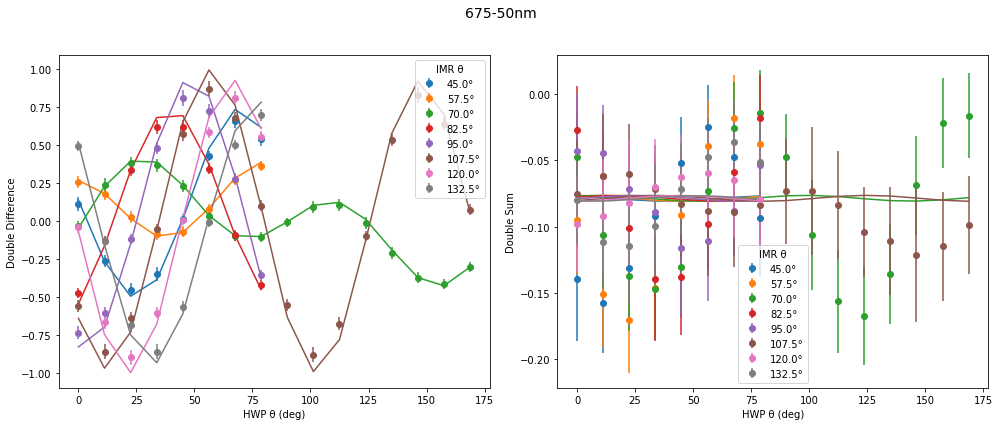

After p0: {'wollaston': {'transmission_ratio': 1.1706700570258768}, 'flc': {'phi': 3.14718220499044, 'delta_theta': -4.86373889956552}, 'optics': {'phi': -2.6762809668223992, 'epsilon': 0.0, 'theta': 5.987170112055857}, 'image_rotator': {'phi': 2.018138807141897, 'delta_theta': 0.39896440148588785}, 'hwp': {'phi': 2.9185595764401917, 'delta_theta': 0.9269707653956334}, 'lp': {'theta': 3.7061669339720336}}
Before p0: {'wollaston': {'transmission_ratio': 1.1706700570258768}, 'flc': {'phi': 3.14718220499044, 'delta_theta': -4.86373889956552}, 'optics': {'phi': -2.6762809668223992, 'epsilon': 0.0, 'theta': 5.987170112055857}, 'image_rotator': {'phi': 2.018138807141897, 'delta_theta': 0.39896440148588785}, 'hwp': {'phi': 2.9185595764401917, 'delta_theta': 0.9269707653956334}, 'lp': {'theta': 3.7061669339720336}}
Iteration #: 2
logl_value: 116.65730955927862
Best Fit Parameters: [ 1.17347773e+00  3.15001844e+00 -3.32364629e+00 -2.63487553e+00
  7.14013891e-03  7.68817047e+00  2.01489915e+00 

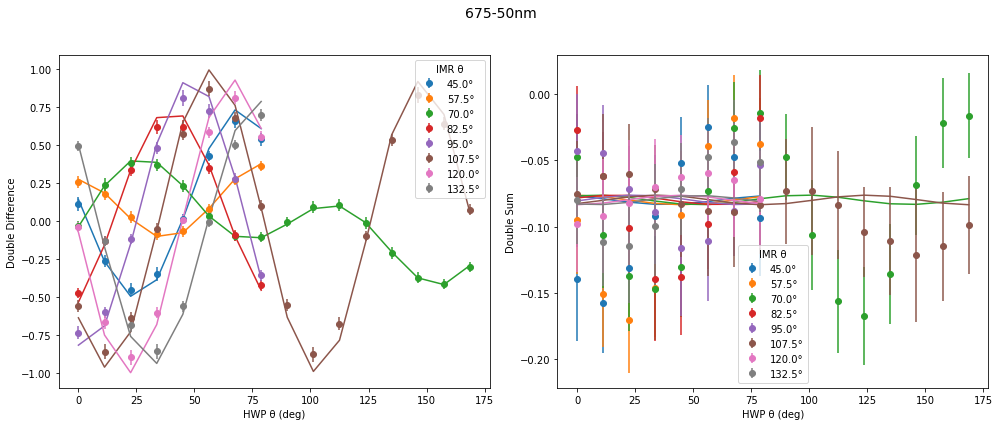

After p0: {'wollaston': {'transmission_ratio': 1.173477728496024}, 'flc': {'phi': 3.1500184446131207, 'delta_theta': -3.3236462864683096}, 'optics': {'phi': -2.634875530423793, 'epsilon': 0.00714013891289992, 'theta': 7.688170472991395}, 'image_rotator': {'phi': 2.014899147660418, 'delta_theta': 0.319139555064476}, 'hwp': {'phi': 2.914505780147109, 'delta_theta': -0.9123605112808331}, 'lp': {'theta': 0.25158715544815935}}
Before p0: {'wollaston': {'transmission_ratio': 1.173477728496024}, 'flc': {'phi': 3.1500184446131207, 'delta_theta': -3.3236462864683096}, 'optics': {'phi': -2.634875530423793, 'epsilon': 0.00714013891289992, 'theta': 7.688170472991395}, 'image_rotator': {'phi': 2.014899147660418, 'delta_theta': 0.319139555064476}, 'hwp': {'phi': 2.914505780147109, 'delta_theta': -0.9123605112808331}, 'lp': {'theta': 0.25158715544815935}}
Iteration #: 3
logl_value: 100.04845074040665
Best Fit Parameters: [ 1.17917334e+00  3.23211528e+00  4.59565548e+00 -1.72912081e+00
  7.87717972e-0

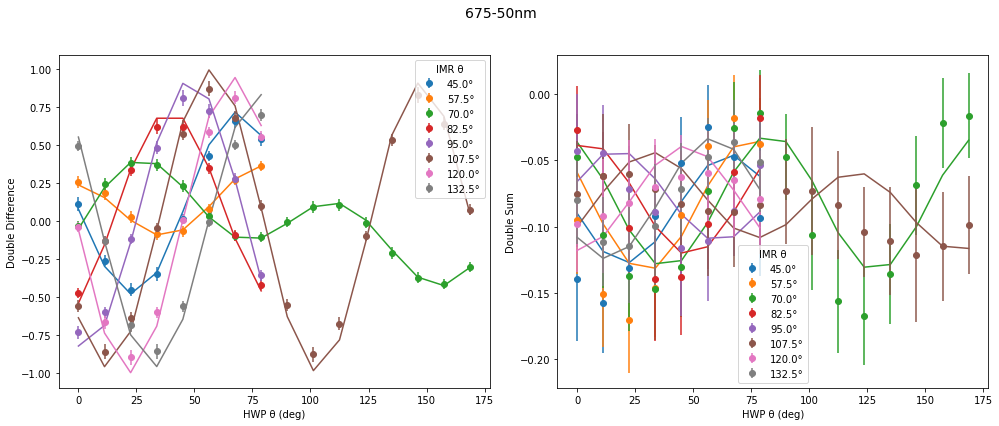

After p0: {'wollaston': {'transmission_ratio': 1.1791733350035623}, 'flc': {'phi': 3.232115281429259, 'delta_theta': 4.595655480117713}, 'optics': {'phi': -1.7291208115859602, 'epsilon': 0.007877179719339895, 'theta': 18.075823362066046}, 'image_rotator': {'phi': 2.0801002514785196, 'delta_theta': -0.9857617898312969}, 'hwp': {'phi': 2.922814841063113, 'delta_theta': 1.0496168081751067}, 'lp': {'theta': 3.551547885950324}}
Before p0: {'wollaston': {'transmission_ratio': 1.1791733350035623}, 'flc': {'phi': 3.232115281429259, 'delta_theta': 4.595655480117713}, 'optics': {'phi': -1.7291208115859602, 'epsilon': 0.007877179719339895, 'theta': 18.075823362066046}, 'image_rotator': {'phi': 2.0801002514785196, 'delta_theta': -0.9857617898312969}, 'hwp': {'phi': 2.922814841063113, 'delta_theta': 1.0496168081751067}, 'lp': {'theta': 3.551547885950324}}
Iteration #: 4
logl_value: 95.03900871475625
Best Fit Parameters: [ 1.18283169e+00  3.22975461e+00  4.99918330e+00 -1.67564943e+00
  3.43076685e-

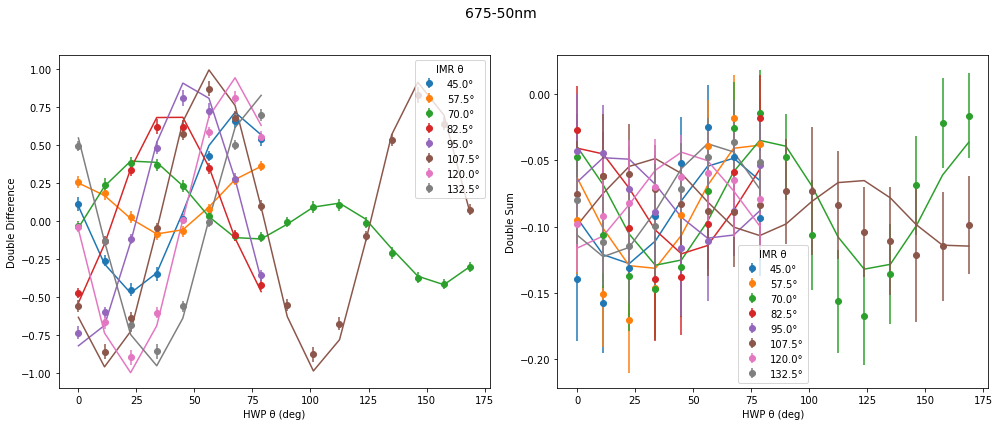

After p0: {'wollaston': {'transmission_ratio': 1.1828316924827904}, 'flc': {'phi': 3.229754611642841, 'delta_theta': 4.999183304404525}, 'optics': {'phi': -1.6756494269669266, 'epsilon': 0.003430766850312633, 'theta': 18.513453365448484}, 'image_rotator': {'phi': 2.068617915227401, 'delta_theta': -0.9997836593926088}, 'hwp': {'phi': 2.9239157974992924, 'delta_theta': -0.10113430537029278}, 'lp': {'theta': 1.5509926179780953}}
Before p0: {'wollaston': {'transmission_ratio': 1.1828316924827904}, 'flc': {'phi': 3.229754611642841, 'delta_theta': 4.999183304404525}, 'optics': {'phi': -1.6756494269669266, 'epsilon': 0.003430766850312633, 'theta': 18.513453365448484}, 'image_rotator': {'phi': 2.068617915227401, 'delta_theta': -0.9997836593926088}, 'hwp': {'phi': 2.9239157974992924, 'delta_theta': -0.10113430537029278}, 'lp': {'theta': 1.5509926179780953}}
Iteration #: 5
logl_value: 95.01818094633279
Best Fit Parameters: [ 1.18304752e+00  3.23011784e+00  4.99994297e+00 -1.67767502e+00
  3.2759

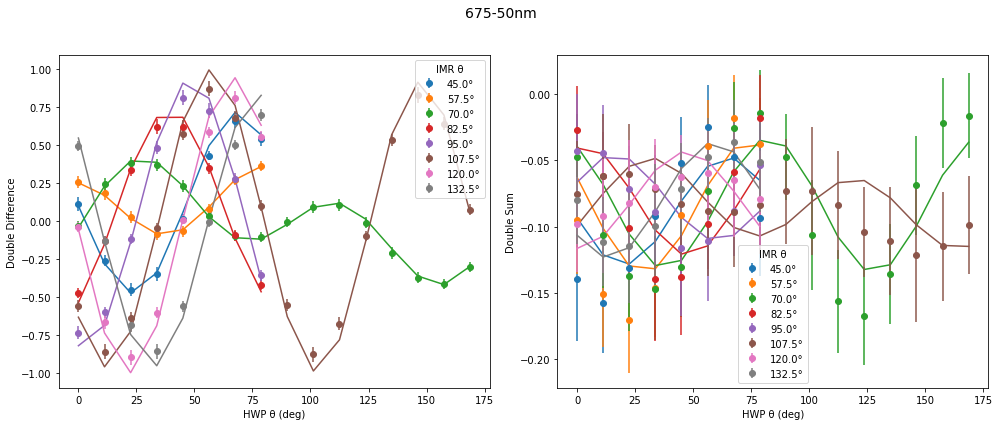

After p0: {'wollaston': {'transmission_ratio': 1.183047517829734}, 'flc': {'phi': 3.230117838204075, 'delta_theta': 4.999942974108254}, 'optics': {'phi': -1.6776750221409316, 'epsilon': 0.0032759180145927793, 'theta': 18.49795342499462}, 'image_rotator': {'phi': 2.0680442799582845, 'delta_theta': -0.9999895395429261}, 'hwp': {'phi': 2.9241125806261454, 'delta_theta': -0.27737813997523064}, 'lp': {'theta': 1.2234664908639514}}


TypeError: expected str, bytes or os.PathLike object, not ndarray

In [7]:
# Unpolarized light for s_in as there is LP in the system already
s_in = np.array([1, 0, 0, 0])
bounds = [ 
    (0, 2),  # em_gain
    (0.4 * 2 * np.pi, 0.6 * 2 * np.pi),  # delta_FLC
    (-5, 5),  # rot_FLC
    (-0.5 * 2 * np.pi, 0.5 * 2 * np.pi),  # delta_opts
    (0, 0.1),  # epsilon_opts
    (-90, 90),  # rot_opts
    ((delta_derot - delta_derot * 0.1) * 2 * np.pi, (delta_derot + delta_derot * 0.1) * 2 * np.pi),  # delta_derot
    (-1, 1),  # offset_derot
    ((delta_HWP - delta_HWP * 0.1) * 2 * np.pi, 0.5 * 2 * np.pi),  # delta_HWP
    (-5, 5),  # offset_HWP
    (-5, 5)  # theta_pol
]

# Counters for iterative fitting
iteration = 1
previous_logl_value = 1000000
new_logl_value = 0

while abs(previous_logl_value - new_logl_value) > 0.01 * abs(previous_logl_value):
    print("Before p0: " + str(p0))
    if iteration > 1: 
        previous_logl_value = new_logl_value
    result, new_logl_value = inst.minimize_system_mueller_matrix(p0, system_mm, 
        interleaved_values, interleaved_stds, configuration_list, s_in = s_in,
        process_dataset = inst.process_dataset, 
        process_errors = inst.process_errors, 
        process_model = inst.process_model, bounds = bounds)
    
    # Print statements
    print("Iteration #: " + str(iteration))
    print("logl_value: " + str(new_logl_value))
    print("Best Fit Parameters: " + str(result.x))

    # Making a plot
    updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
    model = inst.model(result.x, p0_keywords, updated_system_mm, configuration_list, 
    process_model = inst.process_model)

    inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
        configuration_list, wavelength = wavelength_string)

    # Updating p0 for next time
    inst.update_p0(p0, result.x)
    print("After p0: " + str(p0))

    iteration += 1

filename = f"{wavelength_string}_restrictive_HWP_IMR_FLC_no_dichroic_best_fit"
np.save(wavelength_string + filename, result.x)

# Step 6: Plot model with best fit

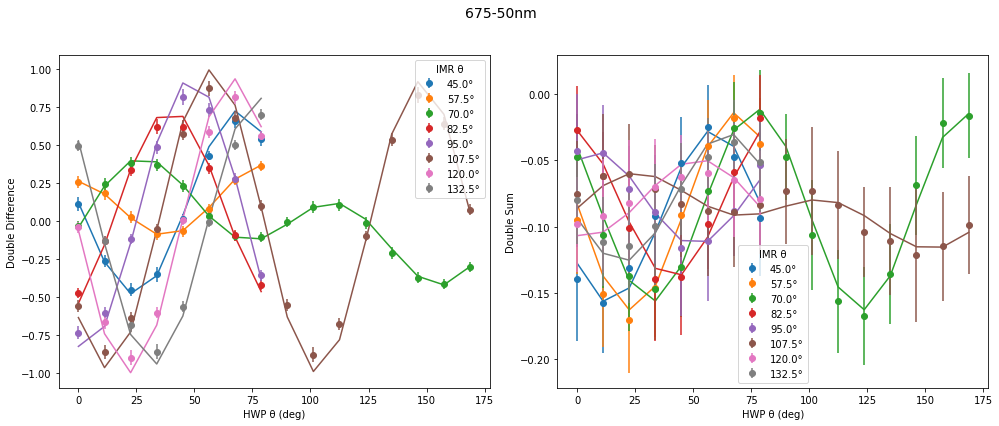

In [13]:
# Generate model with p0 keywords but scipy minimized results
# print(result.x)
# print(p0_keywords)

# Manually adjusting for a good fit
dichroic_phi = 0 # (waves)
dichroic_theta = 0 # (degrees)
# result.x = [2 * np.pi * dichroic_phi, dichroic_theta]

updated_system_mm = inst.update_system_mm(result.x, p0_keywords, system_mm)
model = inst.model(result.x, p0_keywords, system_mm, configuration_list, 
    process_model = inst.process_model)

inst.plot_data_and_model(interleaved_values, interleaved_stds, model, 
    configuration_list, wavelength = wavelength_string)